# Conditional stalling for uniformily distributed addresses

## Publication
This work has an associated publication:

Title: "Boosting performance of HLS dataflows with datadependencies using fast conditional stalling"

Authors: Tobías Alonso, Gustavo Sutter, Sergio Lopez-Buedo, and Jorge E. López de Vergara

In [ ]:
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
import matplotlib.pyplot as plt

from conditional_stalling import *
from scipy.stats import binom


In [2]:
import matplotlib
font = {'family':'serif','weight':'normal','size':10}
matplotlib.rc('font', **font)

colors = ['k','b','c','g','y','m','r']
markers = [ '.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
paper_linewidth = 3.4876

In [3]:
# %matplotlib qt

# $\overline{II}_{sys}$  for different cardinalities

In [4]:
C_idx_high = 10
C_list= [2**i for i in range(1,C_idx_high+1)] # id range size  
L_high = 10
nthr=6
size = 2
SIZE_OF_SIM_BLOCK = 100000
Simulation_IIs = []
for L in tqdm(range(0,L_high+1)):
  def test_kernel(x):
    return simulate_stall_stage(L,x,seed=0,num_of_elem = SIZE_OF_SIM_BLOCK)

  with Pool(processes=nthr) as p:
    res = p.map(test_kernel,C_list)
    Simulation_IIs += [res]
Simulation_IIs = np.array(Simulation_IIs)


100%|██████████| 11/11 [00:11<00:00,  1.05s/it]


Other plots to evalute the approximation

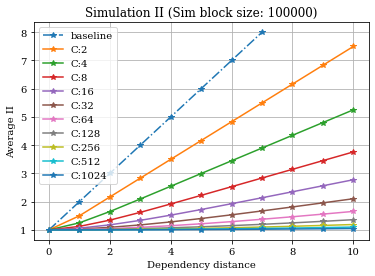

In [5]:
plt.figure()

plt.plot(range(0,L_high-2),range(1,L_high-1),"*-.", label="baseline")
dep_distance = [i for i in range(0,L_high+1)]
for c,C in enumerate(C_list):
  curve = Simulation_IIs[:,c]
  plt.plot(dep_distance,curve,"*-",label="C:%d"%C)
  

plt.legend()
plt.title("Simulation II (Sim block size: %d)" % SIZE_OF_SIM_BLOCK)
plt.xlabel("Dependency distance")
plt.ylabel("Average II")
plt.grid()

## Exact solution to compute $\overline{II}_{sys}$ 




In [6]:
L_high = min(12,L_high)
L_axis = range(0,L_high)
clr_idx = 1-len(colors)

exact_matrix= []
for C_idx in tqdm(range(C_idx_high)):
  C = 2**(C_idx+1)
  exact_matrix += [[ get_II_from_HMM(L=l,cardinality=C) for l in L_axis]]

100%|██████████| 10/10 [00:02<00:00,  4.74it/s]


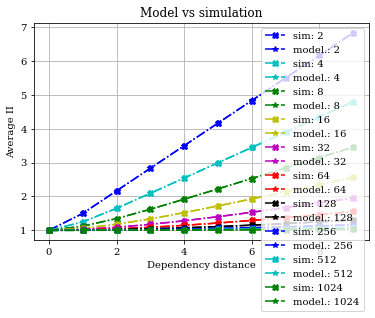

In [7]:
# Approx
plt.figure()
plt.title("Model vs simulation")
plt.xlabel("Dependency distance")
plt.ylabel("Average II")
plt.grid()
DD = L_axis
clr_idx = 1-len(colors)

for C_idx in range(C_idx_high):
  C = 2**(C_idx+1)
  curve = Simulation_IIs[:L_high,C_idx]
  curve_exact = exact_matrix[C_idx][:L_high]
  plt.plot(DD,curve,colors[clr_idx]+"X-.",label="sim: %d"%C)
  plt.plot(DD,curve_exact,colors[clr_idx]+"*-.",label="model.: %d"%C)
  clr_idx +=1
plt.legend()

Relative Error plot

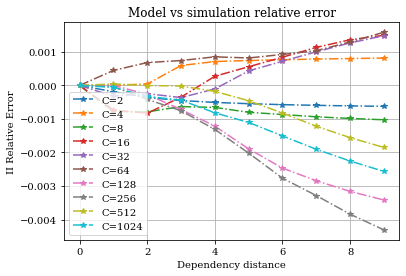

In [8]:
#relative Error plot
plt.figure()
plt.title("Model vs simulation relative error")
plt.xlabel("Dependency distance")
plt.ylabel("II Relative Error")
plt.grid()
for C_idx in range(C_idx_high):
  C = 2**(C_idx+1)
  curve = Simulation_IIs[:L_high,C_idx]
  curve_exact = exact_matrix[C_idx][:L_high]
  diff = [(a-b)/a for a,b in zip(curve,curve_exact)]
  plt.plot(DD,diff,"*-.",label="C=%d"%C)
plt.legend()

## $\overline{II}_{sys}$ approximations

In [9]:
def approx_II(L,C):
  ''' get exact value or approximation of II'''
  Pc = 1/C
  first_approx = lambda L,Pc :1 + (L*L + L)*Pc/2
  II_lim = 1.35
  L_lim = (-Pc/2 + np.sqrt(Pc*Pc/4 - 4*(1-II_lim)*Pc/2 ))/Pc
  if L <= L_lim:
    return first_approx(L,Pc)
  else:
    b = (2*L_lim+1)*Pc/2
    return II_lim + b*(L-L_lim )

Relative Error plot (Paper figure)

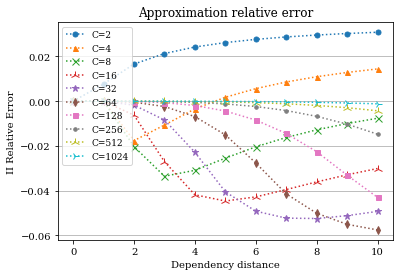

In [10]:
markers = ['o', '^','x','2',  '*', 'd', 's', '.','2','4',  '1', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
fig = plt.figure()
plt.title("Approximation relative error")
plt.xlabel("Dependency distance")
plt.ylabel("II Relative Error")
plt.grid(True,axis='y')
DD = range(0,L_high+1)
marker_idx=0
for C_idx in range(C_idx_high):
  C = 2**(C_idx+1)
  curve =  [ get_II_from_HMM(L=l,cardinality=C) for l in DD]
  curve_approx = [ approx_II(l,C) for l in DD]
  diff = [(a-b)/a for a,b in zip(curve,curve_approx)]
  
  markersize = 5 if markers[marker_idx] in ['o', '^','d','s'] else (9 if markers[marker_idx]=='2' else 7)
  plt.plot(DD,diff,markers[marker_idx]+":",markersize=markersize,label="C=%d"%C)
  marker_idx +=1
plt.legend(prop={'size': 9},loc='upper left')


Other plots to evalute the approximation

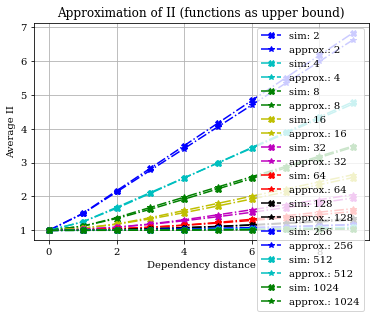

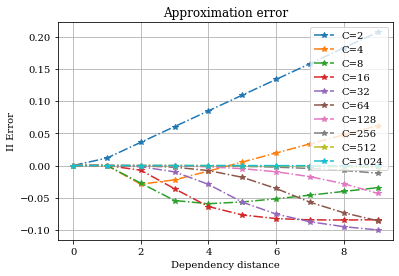

In [11]:
# Approx
plt.figure()
plt.title("Approximation of II (functions as upper bound)")
plt.xlabel("Dependency distance")
plt.ylabel("Average II")
plt.grid()
L_high = 10
DD = range(0,L_high)

clr_idx = 1-len(colors)
for C_idx in range(C_idx_high):
  C = 2**(C_idx+1)
  curve =  [ get_II_from_HMM(L=l,cardinality=C) for l in DD]
  curve_approx = [ approx_II(l,C) for l in DD]
  plt.plot(DD,curve,colors[clr_idx]+"X-.",label="sim: %d"%C)
  plt.plot(DD,curve_approx,colors[clr_idx]+"*-.",label="approx.: %d"%C)
  clr_idx +=1
plt.legend()


# Error plot
plt.figure()
plt.title("Approximation error")
plt.xlabel("Dependency distance")
plt.ylabel("II Error")
plt.grid()

for C_idx in range(C_idx_high):
  C = 2**(C_idx+1)
  curve =  [ get_II_from_HMM(L=l,cardinality=C) for l in DD]
  curve_approx = [ approx_II(l,C) for l in DD]
  diff = [a-b for a,b in zip(curve,curve_approx)]
  plt.plot(DD,diff,"*-.",label="C=%d"%C)
plt.legend()
  

## Simple $\overline{II}_{sys}$ upper bound (tight for L << C)

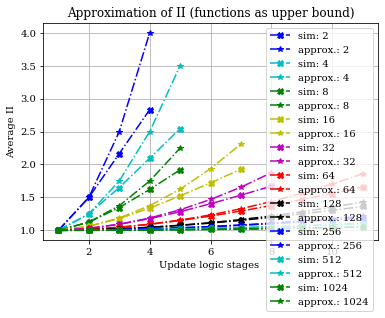

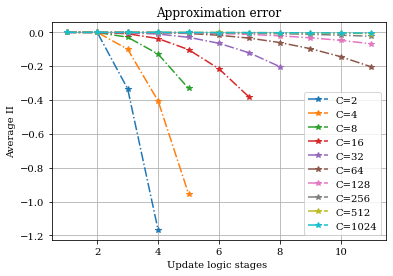

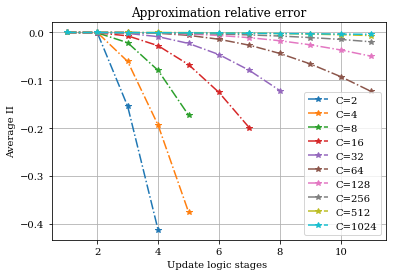

In [12]:
def simple_approx_II(L,C):
  # next formula is the close form of (C-L)/C + sum([i/C for i in range(2,L+2)]) 2,L+2)])
  return 1 + (L*L + L)/(2*C)


# Approx
plt.figure()
plt.title("Approximation of II (functions as upper bound)")
plt.xlabel("Update logic stages ")
plt.ylabel("Average II")
plt.grid()
L_high = 10

clr_idx = 1-len(colors)
for C_idx in range(C_idx_high):
  C = 2**(C_idx+1)
  max_L = min(int(C**.5)+2,L_high)
  curve = Simulation_IIs[:max_L+1,C_idx]
  L_axis = range(0,max_L+1)
  Stages = [l+1 for l in L_axis]
  curve_approx = [ simple_approx_II(l,C) for l in L_axis]
  plt.plot(Stages,curve,colors[clr_idx]+"X-.",label="sim: %d"%C)
  plt.plot(Stages,curve_approx,colors[clr_idx]+"*-.",label="approx.: %d"%C)
  clr_idx +=1
plt.legend()


# Error plot
plt.figure()
plt.title("Approximation error")
plt.xlabel("Update logic stages ")
plt.ylabel("Average II")
plt.grid()

for C_idx in range(C_idx_high):
  C = 2**(C_idx+1)
  max_L = min(int(C**.5)+2,L_high)
  curve = Simulation_IIs[:max_L+1,C_idx]
  L_axis = range(0,max_L+1)
  Stages = [l+1 for l in L_axis]
  curve_approx = [ simple_approx_II(l,C) for l in L_axis]
  diff = [a-b for a,b in zip(curve,curve_approx)]
  plt.plot(Stages,diff,"*-.",label="C=%d"%C)
plt.legend()
  
#relative Error plot
plt.figure()
plt.title("Approximation relative error")
plt.xlabel("Update logic stages ")
plt.ylabel("Average II")
plt.grid()
for C_idx in range(C_idx_high):
  C = 2**(C_idx+1)
  max_L = min(int(C**.5)+2,L_high)
  curve = Simulation_IIs[:max_L+1,C_idx]
  L_axis = range(0,max_L+1)
  Stages = [l+1 for l in L_axis]
  curve_approx = [ simple_approx_II(l,C) for l in L_axis]
  diff = [(a-b)/a for a,b in zip(curve,curve_approx)]
  plt.plot(Stages,diff,"*-.",label="C=%d"%C)
plt.legend()


# Distribution of $\overline{II}_{sys}$
Distribution of II obtained as number of cycles to process a given block size

### Time series visualization

In [13]:
%%time
L=1
cardinality = 256
window_size = 1000
num_of_elem = 50000
P_bb, cycle_count = time_series_simulation_stall_stage(L,cardinality,seed=1,window_size = window_size,
                                                      num_of_elem = num_of_elem)

CPU times: user 474 ms, sys: 0 ns, total: 474 ms
Wall time: 474 ms


Text(0.5, 0, 'Window id')

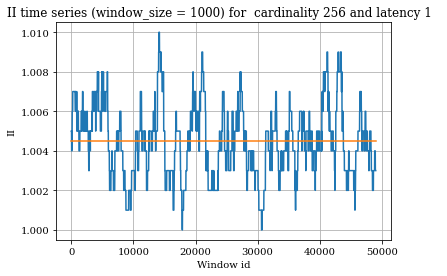

In [15]:
plt.figure()
plt.title("II time series (window_size = %d) for  cardinality %d and latency %d  " %(window_size, cardinality, L))
plt.grid()
II_plot = np.array(cycle_count)/window_size
plt.plot(range(len(cycle_count)),II_plot)
plt.plot([0,len(cycle_count)-1],[np.mean(II_plot),np.mean(II_plot)])
plt.ylabel("II")
plt.xlabel("Window id")

Plot CDF

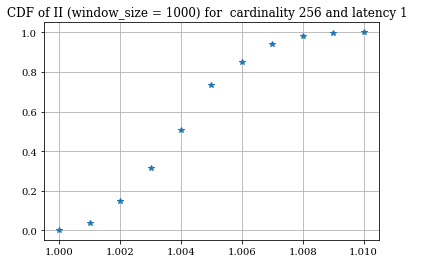

In [16]:
x_axis,CDF= get_II_CDF_from_cycle_series(cycle_count,window_size=window_size)
plt.figure()
plt.title("CDF of II (window_size = %d) for  cardinality %d and latency %d  " %(window_size, cardinality, L))
plt.plot(x_axis,CDF,"*")
plt.grid(True)

## Simulation for different cardinalities and latencies

In [17]:
C_idx_high = 10
C= [2**i for i in range(1,C_idx_high+1)] # id range size  
L_high = 10
nthr=6
window_size=1000
num_of_elem = 100000
Simulation_II_time_series = []
for L in tqdm(range(0,L_high+1)):
  def test_kernel(x):
    return time_series_simulation_stall_stage(L,x,seed=0,window_size = window_size,num_of_elem = num_of_elem)

  with Pool(processes=nthr) as p:
    res = p.map(test_kernel,C)
    Simulation_II_time_series += [res]


100%|██████████| 11/11 [00:29<00:00,  2.68s/it]


### $\overline{II}_{sys}$ Density (Violin) plots 
Paper figure

100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


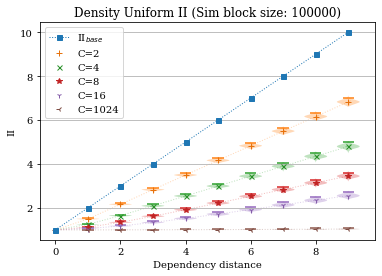

In [18]:
markers = [ '+', 'x', '*', '1', '3', '.','2','4', 's', 'p', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
Max_DD_plot=8
fig = plt.figure()
plt.plot(range(0,L_high),range(1,L_high+1),"s",linestyle='dotted',markersize=5,zorder=2,linewidth=1.0, label="II$_{base}$")
idx=0
for c in tqdm([0,1,2,3,9]):
  C = 2**(c+1)
  DD_array = [DD for DD in range(Max_DD_plot+2)]
  data = [ np.array(Simulation_II_time_series[DD][c][1])/window_size for DD in DD_array[1:]]
  quantiles = [[.99] for i in DD_array[1:]]
  violin_parts = plt.violinplot(data, DD_array[1:], points=60, widths=0.7, showmeans=False, bw_method=0.5,showextrema=False,
                       quantiles=quantiles)
  av_curve = [ Simulation_II_time_series[DD][c][0] for DD in DD_array]
  curve_color = violin_parts['bodies'][0].get_facecolor()[0]
  if 'x'==markers[idx]:
    plt.plot(DD_array[1:],av_curve[1:],markers[idx],markersize=5,color=curve_color[:3]*.9,label="C=%d"%C)
  else:
    plt.plot(DD_array[1:],av_curve[1:],markers[idx],color=curve_color[:3]*.9,label="C=%d"%C)
  plt.plot(DD_array,av_curve,markers[clr_idx],color=curve_color,linestyle='dotted',linewidth=1.0, zorder=1)
  idx+=1
  
plt.legend(prop={'size': 10})
plt.title("Density Uniform II (Sim block size: %d)" % SIZE_OF_SIM_BLOCK)
plt.xlabel("Dependency distance")
plt.ylabel("II")
plt.grid(True,axis='y')

# Distributions

### Exact distribution solution for L=1 and uniform distribution

Given a block of $W$ packets with uniformly distributed addresses, we want to get $P(II_{sys})$.
When $DD=1$ and the pipeline is full, there are two packet acceptance sequences: 
- $S_0$: the new packet is accepted in the next cycle ($S_0$) 
- $S_1$: it waits one cycle and it is accepted in the following one.  

It is easy to see that the number of $S_1$ ($N_1$) $\sim B(n=W,p = \frac{1}{C})$. 

Given that the block takes $W - N_1 + N_1\cdot 2 $ cycles to be processed, $P(II_{sys}= cycles/W) = P(N_1= cycles -W )$. 
From this, it follows that $\overline{II}_{sys}= 1 + p =1+\frac{1}{C}$. 

In [19]:
%%time
L=1
cardinality = 32
window_size = 200
num_of_elem = 500000
II_sim, cycle_count_series = time_series_simulation_stall_stage(L,cardinality,seed=1,window_size = window_size,
                                                      num_of_elem = num_of_elem)

CPU times: user 2.33 s, sys: 0 ns, total: 2.33 s
Wall time: 2.33 s


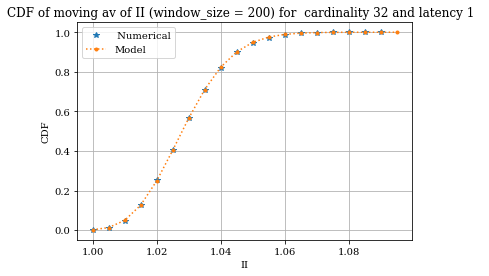

In [33]:
x_axis,CDF= get_II_CDF_from_cycle_series(cycle_count_series,window_size=window_size)

### Plot simulation CDF
plt.figure()
plt.title("CDF of moving av of II (window_size = %d) for  cardinality %d and latency %d  " %(window_size, cardinality, L))
plt.plot(x_axis,CDF,"*",label=" Numerical")
plt.xlabel("II")
plt.ylabel("CDF")
plt.grid(True)



### Plot model CDF
n = int(window_size)
p = 1/cardinality
dist = binom(n, p)

x = [i for i in range(n+1)]
CDF = dist.cdf(x)
CDF_II = []
approx_x_axis = []

for cycles,prob in zip(range(n,n*(L+1)+1),CDF):
  CDF_II += [prob]
  approx_x_axis += [cycles/window_size]
  if approx_x_axis[-1]>x_axis[-1]:
    break

plt.plot(approx_x_axis,CDF_II,".:",label="Model")
plt.legend()

### Approximation of $\overline{II}_{sys}$ distribution using the binomial for general L

#### Simple stateless model

Given W elements, we want to get the probability of processing them in C cycles. Then:

Then, we can get the probability of II as $II= cycles/W$

We simplify the problem assuming a stateless system with only two possible sequencies emerging for each element:
- $S0$: No colission -> requires 1 cycle. $P(S0) = \sum_{i=2^{L-2}}^{i=2^{L-1}-1}\pi_i$. 
where $\pi$ is the steady state probabilities vector of the hidden markov model.
- $S1$: average colission sequence  -> requires mean(colission seq. cycles) = $\overline{C_c} = (\overline{II}-P(S0))/P(S1)$. Where,  $P(S1) = 1- P(S0)$ and $\overline{II}$ is given by the hidden markov model.

Then: 

$(1): \: X_0 \sim B\binom{n=W}{p = P(S0)}$. Where $X_0 \in [0..W]$, is the number of ocurrancies of $S0$

$(2): \: cycles = X_0 + (W-X_0)*\overline{C_c}$

So, 

$(3): \: P(II=cycles/W) = P(X_0 = \frac{W \cdot \overline{C_c}-cycles}{\overline{C_c}-1} ) $

Here, $cycles$ would generally take not integer numbers.



<!-- $P(II=cycles/W) = P(X_0 = (W \cdot \overline{C_c}-cycles)/(\overline{C_c}-1)$ -->


In [34]:
%%time
L=5
cardinality = 64
window_size = 1000
num_of_elem = 400000
II_sim, cycle_count_series = time_series_simulation_stall_stage(L,cardinality,seed=1,window_size = window_size,
                                                      num_of_elem = num_of_elem)

CPU times: user 4.38 s, sys: 21.6 ms, total: 4.4 s
Wall time: 4.4 s


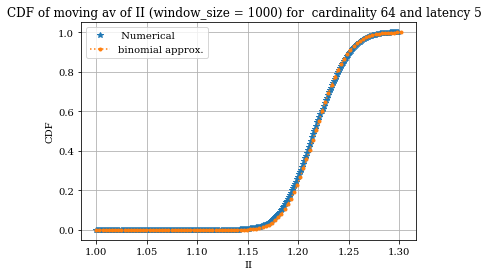

In [35]:
x_axis,CDF= get_II_CDF_from_cycle_series(cycle_count_series,window_size=window_size)

### Plot simulation CDF
plt.figure()
plt.title("CDF of moving av of II (window_size = %d) for  cardinality %d and latency %d  " %(window_size, cardinality, L))
plt.plot(x_axis,CDF,"*",label=" Numerical")
plt.xlabel("II")
plt.ylabel("CDF")
plt.grid(True)


### Plot Model CDF
def get_binomial_model(L,cardinality):
  model_II = get_II_from_HMM(L,cardinality)
  steady_probs = get_Markov_steady_state_probs(get_uniform_stocastic_matrix(L,cardinality))
  P_s0 = sum(steady_probs[len(steady_probs)//2:])
  P_s1 = 1 - P_s0
  mean_s1_cycles = (model_II-P_s0)/P_s1
  return P_s0,mean_s1_cycles

P_s0,mean_s1_cycles =  get_binomial_model(L,cardinality)

n = int(window_size)
p = P_s0
dist = binom(n, p)

x = [i for i in range(n+1)]
CDF = dist.cdf(x)
CDF_II = []
approx_x_axis = []

for x,prob in zip(range(n,-1,-1),CDF[-1::-1] ):
  CDF_II += [1-prob]
  cycles = x + (n-x)*mean_s1_cycles
  approx_x_axis += [cycles/window_size]
  if approx_x_axis[-1]>x_axis[-1]:
    break
  
plt.plot(approx_x_axis,CDF_II,".:",label="binomial approx.")
plt.legend()


# Behaviour when incrementing the pipeline depth

Paper Figure

In [36]:

def period_estim(Tc,Tpp,s):
  return Tc/s+Tpp if s>1 else Tc

Max_stages= 10
Tc = 8
Tpp = .9

II_update = 1

comb_freq = 1000/Tc # in MHz

latency_axis = [i for i in range(1,Max_stages+1)]

no_opt_rate = []
for update_stages in tqdm(latency_axis):
    period = period_estim(Tc,Tpp,update_stages)
    freq = 1/period*1000/comb_freq # normalized freq
    no_opt_rate += [freq/(update_stages)]

opt_rate = []
for cardinality in tqdm([2**i for i in range(1,10)]):
  curve = []
  for update_stages in latency_axis:
    period = period_estim(Tc,Tpp,update_stages)
    freq = 1/period*1000/comb_freq # normalized freq
    II = get_II_from_HMM(L=update_stages-1,cardinality=cardinality)
    curve += [freq/II]
    
  opt_rate += [curve]


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


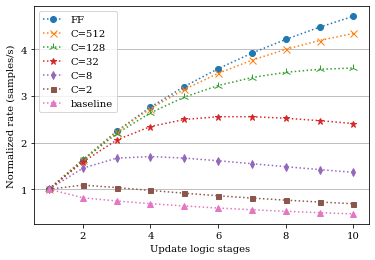

In [37]:
markers = ['o', '^','x','2',  '*', 'd', 's', '.','2','4',  '1', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
fig = plt.figure()

feed_forward = [Tc/(period_estim(Tc,Tpp,s)) for s in latency_axis]
plt.plot(latency_axis,feed_forward,markers[0]+":",label="FF")


max_card_idx = 9
marker_idx = 2
for i,cardinality in enumerate([2**i for i in range(max_card_idx,0,-1)]):
  C_idx = max_card_idx-1-i
  if C_idx in [1,3,5,7,9]:
    continue
  

  markersize = 5 if markers[marker_idx] in ['o', '^','d','s'] else (9 if markers[marker_idx]=='2' else 7)
  plt.plot(latency_axis,opt_rate[C_idx],markers[marker_idx]+":",markersize=markersize,label="C=%d" %cardinality)
  marker_idx +=1

plt.plot(latency_axis,no_opt_rate,markers[1]+":",label="baseline")

plt.legend(prop={'size': 10},loc='upper left')
plt.xlabel("Update logic stages ")
plt.ylabel("Normalized rate (samples/s)")
plt.grid(True,axis='y')